In [22]:
import pandas as pd
from joblib import dump
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from joblib import load


In [23]:
train_df_raw = pd.read_csv('data/train_rosters.csv')
eval_df_raw = pd.read_csv('data/eval_rosters.csv')

In [24]:
train_df = train_df_raw.copy()
eval_df = eval_df_raw.copy()

train_df = train_df.fillna(-1)
eval_df = eval_df.fillna(-1)

train_df.head()

,Unnamed: 0,index,num_workers,num_days,num_shifts,num_tracks,num_skills,staff_req_sparcity,staff_avail_sparcity,avg_num_skills_of_each_worker,...,deviations_skill_staffing_from_mean,diff_available_workers_and_staffing_req_across_shifts,diff_average_avail_workers_and_current_avail_workers,deviations_current_avail_workers_from_avg,max_possible_coverage,available_shifts_less_than_max,total_workers_required_to_fill_roster,avg_shifts_required_less_than_max,lpr_val,target
0,0,"[0, 0, 0, 0, 0]",12,4,6,3,3,0.057099,0.104167,1.0,...,-0.036,8,8.0,11.085,1.777027,False,148.0,True,0.000000e+00,0
1,1,"[0, 0, 0, 0, 1]",12,4,6,3,3,0.057099,0.104167,1.0,...,-0.036,8,8.0,11.085,1.777027,False,148.0,True,0.000000e+00,0
2,2,"[0, 0, 0, 0, 2]",12,4,6,3,3,0.057099,0.104167,1.0,...,-1.347,8,8.0,11.085,1.777027,False,148.0,True,0.000000e+00,0
3,3,"[0, 0, 0, 1, 0]",12,4,6,3,3,0.057099,0.104167,1.0,...,-1.347,7,7.0,9.699,1.777027,False,148.0,True,0.000000e+00,0
4,4,"[0, 0, 0, 1, 1]",12,4,6,3,3,0.057099,0.104167,1.0,...,0.619,7,7.0,9.699,1.777027,False,148.0,True,6.611818e-13,0


In [25]:
def pop_features(df, features):
    for feat in features:
        df.pop(feat)

remove_features = ['Unnamed: 0', 'index',
                   "med_num_skills_of_each_worker", "avg_num_skills_of_each_worker",
                   "chi_num_skills_of_each_worker",
                   "diff_avg_skill_penalty_and_worker_penalty",
                   "local_skill_demand",
                   "deviations_skill_staffing_from_mean",
                   "num_days", 'num_workers', "staff_req_sparcity", "skill_scarcity"
                   ]



pop_features(train_df, remove_features)
pop_features(eval_df, remove_features)
print(train_df.head)


<bound method NDFrame.head of          num_shifts  num_tracks  num_skills  staff_avail_sparcity  \
0                 6           3           3              0.104167   
1                 6           3           3              0.104167   
2                 6           3           3              0.104167   
3                 6           3           3              0.104167   
4                 6           3           3              0.104167   
...             ...         ...         ...                   ...   
1466868           7           2           1              0.467532   
1466869           7           2           1              0.467532   
1466870           7           2           1              0.467532   
1466871           7           2           1              0.467532   
1466872           7           2           1              0.467532   

         worker_is_available  worker_skill_penalty  worker_max_avail  \
0                          1                     0              23.0 

In [26]:
y_train = train_df.pop('target').values
y_eval = eval_df.pop('target').values

y_train =  np.ravel(y_train, order='C')
y_test =  np.ravel(y_eval, order='C')

X_train = train_df.values
X_test = eval_df.values

scaler = preprocessing.StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

dump(scaler, f'models/scaler.joblib')

['models/scaler.joblib']

In [27]:
def max_prune(y):
    size = len(y)
    total_required = np.sum(y)
    max_prune = size - total_required
    return max_prune/size

def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return false_negative_rate(cm)

def fnr_complement_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return 1 - false_negative_rate(cm)

def false_negative_rate(cm):
    return round(cm[1][0] / (cm[1][0] + cm[1][1]), 3)

def negative_pred_val(cm):
    return round(cm[0][0] / (cm[0][0] + cm[1][0]), 3)

def prune_percentage(cm):
    return round( (cm[0][0] + cm[1][0]) / (np.sum(cm[:])), 3)

def print_metrics(clf):
    scores = cross_val_score(clf, X_test, y_test, cv=10, scoring='accuracy')
    print("Acc cv: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, X_test, y_test, cv=10, scoring='f1_macro')
    print("F1 cv: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    #print("npr = ", negative_pred_val(cm))
    print("fnr = ", false_negative_rate(cm))
    print("prune = ", prune_percentage(cm))

def threshold_to_metrics(clf, threshold=0.99):
    y_pred_p = clf.predict_proba(X_test)

    y_pred_0 = np.where(y_pred_p[:,0] <= threshold, 0, y_pred_p[:,0])
    y_pred_1 = y_pred_p[:,1]

    y_pred = np.where(y_pred_0 > y_pred_1, 0, 1)

    cm = confusion_matrix(y_test, y_pred)
    fnr = false_negative_rate(cm)
    prune_pc = prune_percentage(cm)

    return {"q":threshold, "prune":prune_pc, "fnr": fnr, "cm":cm}

def print_metrics_with_threshold(clf, threshold=0.99):
    metrics = threshold_to_metrics(clf, threshold)
    print(metrics['cm'])
    #print("npr = ", negative_pred_val(cm))
    print("fnr = ", metrics['fnr'])
    print("prune = ", metrics['prune_pc'])



In [28]:
def plot_prune(clf):
    q_metrics = {}
    for q in np.arange(.50, 1, .02):
       q_metrics[q] = threshold_to_metrics(clf, q)['prune']

    lists = sorted(q_metrics.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples

    l1,  = plt.plot(x, y, label='new')
    plt.legend(handles=[l1], loc='upper right')
    plt.show()
    return plt

def plot_max_prune(clf):
    max_prune_pc = max_prune(y_test)
    q_metrics = {}
    for q in np.arange(.50, 1, .02):
       q_metrics[q] = threshold_to_metrics(clf, q)['prune'] / max_prune_pc

    lists = sorted(q_metrics.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples

    l1,  = plt.plot(x, y, label='new')
    plt.legend(handles=[l1], loc='upper right')
    plt.show()
    return plt


In [29]:
def plot_fnr(clf):
    q_metrics = {}
    for q in np.arange(.50, 1, .02):
       q_metrics[q] = threshold_to_metrics(clf, q)['fnr']

    lists = sorted(q_metrics.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples

    l1,  = plt.plot(x, y, label='new')
    plt.legend(handles=[l1], loc='upper right')
    plt.show()
    return plt

In [30]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3, loss='modified_huber', penalty="elasticnet", random_state=0, class_weight='balanced')
sgd.fit(X_train, y_train)
dump(sgd, f'models/sgd.joblib')


['models/sgd.joblib']

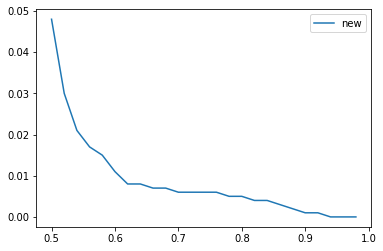

<module 'matplotlib.pyplot' from '/home/thomas/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [31]:
plot_fnr(sgd)

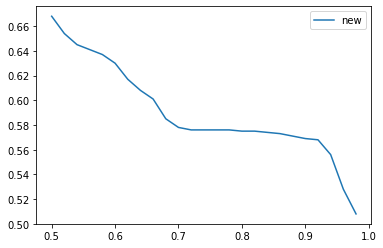

<module 'matplotlib.pyplot' from '/home/thomas/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [32]:
plot_prune(sgd)

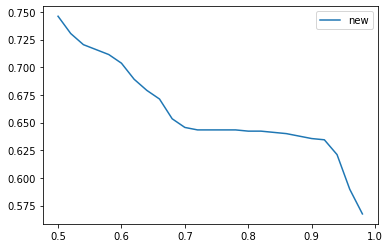

<module 'matplotlib.pyplot' from '/home/thomas/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [33]:
plot_max_prune(sgd)
